# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchaudio
import pandas as pd
import numpy as np
from easydict import EasyDict
import yaml
from sklearn.model_selection import train_test_split
import os
from os import listdir
import matplotlib.pyplot as plt
from os.path import isfile, join
from sklearn.preprocessing import LabelEncoder  
import librosa
import librosa.display
import cv2
import zipfile
from PIL import Image
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import time
import copy
import IPython.display as ipd

import tensorflow_datasets as tfds

# Loading dataset

In [ ]:
# ds = tfds.load('vctk', 
#                split='train', 
#                shuffle_files=True, 
#                data_dir='/content/drive/MyDrive/НИС_2022/accent_recognition')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# !unzip downloads/data.is.ed.ac.uk_bits_hand_1028_3443_VCTK-IyXfMFBjd_cDYW_9GQ4AOewkjaM0aBWvguBMOZrdoIw.zip -d data/

In [ ]:
# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/НИС_2022/accent_recognition/downloads/data.is.ed.ac.uk_bits_hand_1028_3443_VCTK-IyXfMFBjd_cDYW_9GQ4AOewkjaM0aBWvguBMOZrdoIw.zip", 'r')
# zip_ref.extractall("/content/drive/MyDrive/НИС_2022/accent_recognition/downloads/data2")
# zip_ref.close()

In [ ]:
!ls

speaker-info.txt  txt  update.txt  wav48_silence_trimmed


In [2]:
speaker_info_path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/speaker-info.txt'
speakers_dict = {}
accent_dict = {}
speakers = []
labels = []
ban = ['Unknown', 'British', 'NewZealand', 'Indian', 'SouthAfrican', 'Welsh', 'Australian', 'NorthernIrish', 'Irish']
with open(speaker_info_path) as f:
    line = f.readline()
    while line:
        line = f.readline()
        try:
          accent = line.split()[3]
          speaker = line.split()[0]
          if accent in ban:
              continue
          if accent in speakers_dict:
              speakers_dict[accent] += 1
          else:
              speakers_dict[accent] = 1
              accent_dict[accent] = []
          accent_dict[accent].append(speaker)
          speakers.append(speaker)
          labels.append(accent)
        except:
          continue

In [3]:
speakers_dict

{'American': 22, 'Canadian': 8, 'English': 33, 'Scottish': 19}

In [4]:
speakers_train = []
speakers_test = []
labels_train = []
labels_test = []

for key in accent_dict:
    labels_list = [key for _ in range(len(accent_dict[key]))]
    speakers_train_cur, speakers_test_cur, labels_train_cur, labels_test_cur = train_test_split(
        accent_dict[key], labels_list, test_size=0.2, random_state=42)
    
    speakers_train.extend(speakers_train_cur)
    speakers_test.extend(speakers_test_cur)
    labels_train.extend(labels_train_cur)
    labels_test.extend(labels_test_cur)

In [5]:
path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/wav48_silence_trimmed/'
speakers_train_paths = []
speakers_train_labels = []
count = 0
for speaker, label in zip(speakers_train, labels_train):
    speaker_path = path + speaker + '/'
    files = [f for f in listdir(speaker_path) if isfile(join(speaker_path, f))]
    if len(files) > 1000:
        files = files[:1000]
    for file_name in files:
        # if 'mic2' in file_name:
        #     continue
        try:
            wav, sr = librosa.load(speaker_path + file_name, sr=None)
            speakers_train_paths.append(speaker_path + file_name)
            speakers_train_labels.append(label)
        except:
            continue


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [6]:
speakers_test_paths = []
speakers_test_labels = []
count = 0
for speaker, label in zip(speakers_test, labels_test):
    speaker_path = path + speaker + '/'
    files = [f for f in listdir(speaker_path) if isfile(join(speaker_path, f))]
    if len(files) > 1000:
      files = files[:1000]
    for file_name in files:
        # if 'mic2' in file_name:
        #     continue
        try:
            wav, sr = librosa.load(speaker_path + file_name, sr=None)
            speakers_test_paths.append(speaker_path + file_name)
            speakers_test_labels.append(label)
        except:
            continue

In [7]:
le = LabelEncoder()
speakers_train_labels = le.fit_transform(speakers_train_labels)
speakers_test_labels = le.transform(speakers_test_labels)

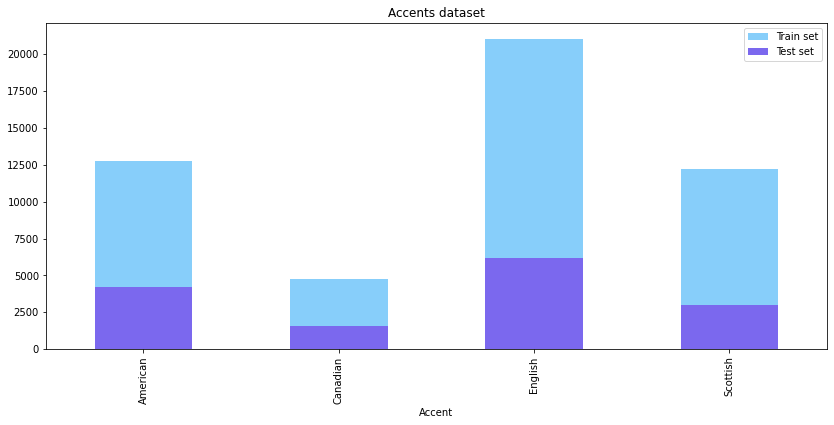

In [8]:
unique_elements_train, counts_elements_train = np.unique(le.inverse_transform(speakers_train_labels), 
                                                         return_counts=True)

unique_elements_test, counts_elements_test = np.unique(le.inverse_transform(speakers_test_labels), 
                                                       return_counts=True)

df = pd.DataFrame({
    'Accent': unique_elements_train,
    'Train set': counts_elements_train,
    'Test set': counts_elements_test
})
  
ax = df.plot(x="Accent", y='Train set', kind="bar", figsize=(14, 6), color="lightskyblue")
df.plot(x="Accent", y='Test set', kind="bar", ax=ax, color="mediumslateblue")
plt.title('Accents dataset')
plt.show()

In [9]:
le.inverse_transform(speakers_train_labels)

array(['English', 'English', 'English', ..., 'Canadian', 'Canadian',
       'Canadian'], dtype='<U8')

## Data sample

In [41]:
# scottish
path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/wav48_silence_trimmed/p234/p234_006_mic1.flac'

In [35]:
sound, sample_rate = torchaudio.load(path)
ipd.Audio(data=sound[0,:],rate=sample_rate)

In [36]:
def get_spec(path):
  waveform, sr = torchaudio.load(path)
  waveform = waveform - waveform.mean()
  fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                                            window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)

  target_length = 256
  n_frames = fbank.shape[0]

  p = target_length - n_frames

  if p > 0:
      m = torch.nn.ZeroPad2d((0, 0, 0, p))
      fbank = m(fbank)
  elif p < 0:
      fbank = fbank[0:target_length, :]

  fbank = fbank.squeeze(0)
  fbank = torch.transpose(fbank, 0, 1)
  norm_mean = -4.71
  norm_std = 4.93
  fbank = (fbank - norm_mean) / (norm_std * 2)
  fbank = torch.reshape(fbank, (1, 128, 256))
  fbank = fbank.expand(3, -1, -1)

  transform = transforms.ToPILImage()
  img = transform(fbank)
  return img

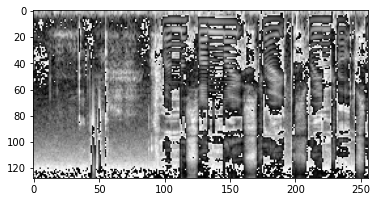

In [44]:
img = get_spec(path)
plt.imshow(img)

In [45]:
# english
path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/wav48_silence_trimmed/p225/p225_006_mic1.flac'

In [39]:
sound, sample_rate = torchaudio.load(path)
ipd.Audio(data=sound[0,:],rate=sample_rate)

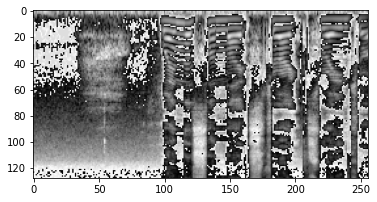

In [46]:
img = get_spec(path)
plt.imshow(img)

In [ ]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    path = os.fspath(file_path)
    wav,sr = librosa.load(path,sr=sr)
    # if wav.shape[0]<5*sr:
    #     wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    # else:
    #     wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
                hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db


def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled



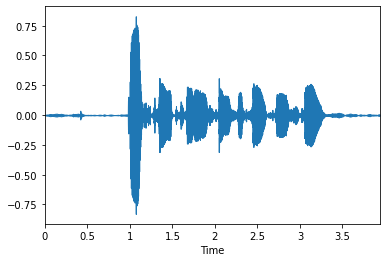

In [ ]:
y, sr = librosa.load(path)

whale_song, _ = librosa.effects.trim(y)
librosa.display.waveplot(whale_song, sr=sr);

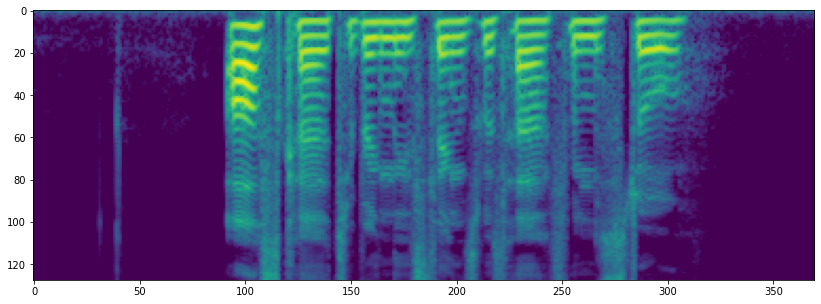

In [ ]:
melspectrogram = spec_to_image(get_melspectrogram_db(path))

plt.figure(figsize=(14, 8))
plt.imshow(melspectrogram)

## Melspectrograms saving

In [ ]:
test_data_path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/melspectograms/validation/'
for speakers_test_path, speakers_test_label in zip(speakers_test_paths, 
                                                   le.inverse_transform(speakers_test_labels)):
    try:
        melspectrogram = spec_to_image(get_melspectrogram_db(speakers_test_path))
    except:
        continue
    img = Image.fromarray(melspectrogram)

    save_path = test_data_path+speakers_test_label
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    img.save(save_path+'/'+os.path.splitext(os.path.basename(speakers_test_path))[0]+'.png')

In [ ]:
train_data_path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/melspectograms/train/'
for speakers_train_path, speakers_train_label in zip(speakers_train_paths, 
                                                   le.inverse_transform(speakers_train_labels)):
    try:
        melspectrogram = spec_to_image(get_melspectrogram_db(speakers_train_path))
    except:
        continue
    img = Image.fromarray(melspectrogram)

    save_path = train_data_path+speakers_train_label
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    img.save(save_path+'/'+os.path.splitext(os.path.basename(speakers_train_path))[0]+'.png')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
res = cv2.resize(melspectrogram, dsize=(128, 64), interpolation=cv2.INTER_CUBIC)

In [ ]:
melspectrogram.shape

(128, 370)

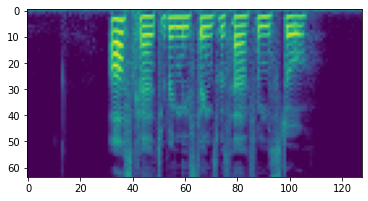

In [ ]:
plt.imshow(res)

In [ ]:
np.reshape(res, (1, 64, 128)).shape

(1, 64, 128)

## Format data

In [ ]:
# def spec_to_image(spec, eps=1e-6):
#     mean = spec.mean()
#     std = spec.std()
#     spec_norm = (spec - mean) / (std + eps)
#     spec_min, spec_max = spec_norm.min(), spec_norm.max()
#     spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
#     # spec_scaled = spec_scaled.astype(np.uint8)
#     return spec_scaled

# class MyDataset(torch.utils.data.Dataset):
#     def __init__(self, audio_paths, labels):
#         self.audio_paths = audio_paths
#         self.labels = labels
#         # self.is_valid = is_valid
#         # if self.is_valid == 1:
#         #     self.aug = # transfoms for validation images
#         # else:                  
#         #     self.aug = # transfoms for training images

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, index):
#         filename = self.audio_paths[index]
#         mel_specgram = spec_to_image(get_melspectrogram_db(filename))[np.newaxis,...]
#         res = cv2.resize(mel_specgram[0, :, :], dsize=(128, 64), interpolation=cv2.INTER_CUBIC)
#         return torch.tensor(np.reshape(res, (1, 64, 128)), dtype = torch.float), self.labels[index]

# train_dataset = MyDataset(speakers_train_paths, speakers_train_labels)
# test_dataset = MyDataset(speakers_test_paths, speakers_test_labels)

In [43]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, audio_paths, labels):
        self.audio_paths = audio_paths
        self.labels = labels
        # self.is_valid = is_valid
        # if self.is_valid == 1:
        #     self.aug = # transfoms for validation images
        # else:                  
        #     self.aug = # transfoms for training images

    def _wav2fbank(self, filename):
        waveform, sr = torchaudio.load(filename)
        waveform = waveform - waveform.mean()
        fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                                                  window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)

        target_length = 256
        n_frames = fbank.shape[0]

        p = target_length - n_frames

        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:target_length, :]
        return fbank
            

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        filename = self.audio_paths[index]
        label_indices = self.labels[index]
        fbank = self._wav2fbank(filename)

        fbank = fbank.squeeze(0)
        fbank = torch.transpose(fbank, 0, 1)
        norm_mean = -4.71
        norm_std = 4.93
        fbank = (fbank - norm_mean) / (norm_std * 2)
        fbank = torch.reshape(fbank, (1, 128, 256))
        fbank = fbank.expand(3, -1, -1)
        # label_indices = torch.FloatTensor(label_indices)
        return fbank, label_indices

train_dataset = MyDataset(speakers_train_paths, speakers_train_labels)
test_dataset = MyDataset(speakers_test_paths, speakers_test_labels)

torch.Size([1, 64, 128])


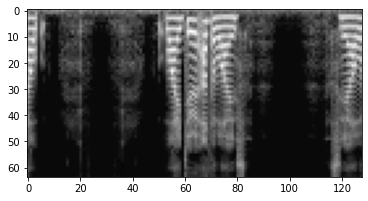

In [ ]:
# def display_img(img,label):
#     print(img.shape)
#     plt.imshow(img[0, :, :], cmap='gray')

# display_img(*train_dataset[4])

In [44]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True)

# Train the CNN

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [46]:
def accuracy(outputs, labels):
    y_pred_softmax = torch.log_softmax(outputs, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [47]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.cuda(), labels.cuda()
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images, labels = images.cuda(), labels.cuda()
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [48]:
class AccentClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(131072, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 4)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [49]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [50]:
model = AccentClassification()
model = model.to(device)

In [51]:
num_epochs = 1
opt_func = torch.optim.Adam
lr = 0.00001
history = fit(num_epochs, lr, model, train_loader, test_loader, opt_func)

Epoch [0], train_loss: 1.0043, val_loss: 1.1518, val_acc: 0.4200


In [52]:
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

y_pred_list = []
y_labels_list = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        y_labels_list.append(labels.numpy())
        images, _ = images.cuda(), labels.cuda()
        y_test_pred = model(images)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
        y_pred_list.append([x for x in y_pred_tags.cpu().numpy()])

y_pred_list = list(chain.from_iterable(y_pred_list))
y_labels_list = list(chain.from_iterable(y_labels_list))

In [53]:
confusion_matrix(y_labels_list, y_pred_list)

array([[2112,   28, 1945,  133],
       [1300,    1,  249,    0],
       [ 650,    0, 3537, 2021],
       [  64,   16, 2296,  652]])

In [54]:
print(classification_report(y_labels_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.51      0.50      0.51      4218
           1       0.02      0.00      0.00      1550
           2       0.44      0.57      0.50      6208
           3       0.23      0.22      0.22      3028

    accuracy                           0.42     15004
   macro avg       0.30      0.32      0.31     15004
weighted avg       0.38      0.42      0.39     15004



In [55]:
le.classes_

array(['American', 'Canadian', 'English', 'Scottish'], dtype='<U8')

# ResNet fine-tuning

## Data loading

In [13]:
import torchvision.models as models

In [14]:
# input_size = 224
batch_size = 32

In [15]:
dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['validation'] = test_loader

In [ ]:
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(input_size),
#         # transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'validation': transforms.Compose([
#         transforms.Resize(input_size),
#         transforms.CenterCrop(input_size),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# data_dir = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/melspectograms/'
# image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation']}
# dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
#                                                    batch_size=batch_size, 
#                                                    shuffle=True, 
#                                                    num_workers=4) for x in ['train', 'validation']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Train & Validate

In [16]:
num_classes = 4
num_epochs = 6

In [17]:
resnet18_pretrained = models.resnet18(pretrained=True)
resnet18_pretrained.fc = nn.Linear(512, num_classes)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [18]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # _, preds = torch.max(outputs, 1)

                    y_pred_softmax = torch.log_softmax(outputs, dim = 1)
                    _, preds = torch.max(y_pred_softmax, dim = 1)    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'validation':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [19]:
resnet18_pretrained = resnet18_pretrained.to(device)

# conv_weight = resnet18_pretrained.conv1[0].weight
# resnet18_pretrained.conv1[0].weight = torch.nn.Parameter(conv_weight.sum(dim=1), keepdim=True)

params_to_update = resnet18_pretrained.parameters()
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)

In [20]:
criterion = nn.CrossEntropyLoss()
# Train and evaluate
resnet18_pretrained, hist = train_model(resnet18_pretrained,
                             dataloaders_dict,
                             criterion, optimizer_ft, 
                             num_epochs=num_epochs)

Epoch 0/5
----------
train Loss: 0.8226 Acc: 0.6444
validation Loss: 1.0156 Acc: 0.5517

Epoch 1/5
----------
train Loss: 0.4245 Acc: 0.8264
validation Loss: 1.2326 Acc: 0.5640

Epoch 2/5
----------
train Loss: 0.2603 Acc: 0.9026
validation Loss: 1.5207 Acc: 0.5623

Epoch 3/5
----------
train Loss: 0.1714 Acc: 0.9400
validation Loss: 1.6709 Acc: 0.5698

Epoch 4/5
----------
train Loss: 0.1160 Acc: 0.9617
validation Loss: 1.8186 Acc: 0.5636

Epoch 5/5
----------
train Loss: 0.0824 Acc: 0.9737
validation Loss: 1.8824 Acc: 0.5625

Training complete in 83m 55s
Best val Acc: 0.569781


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

y_pred_list = []
y_labels_list = []
resnet18_pretrained.eval()
with torch.no_grad():
    for batch in dataloaders_dict['validation']:
        images, labels = batch
        y_labels_list.append(labels.numpy())
        images, _ = images.cuda(), labels.cuda()
        y_test_pred = resnet18_pretrained(images)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
        y_pred_list.append([x for x in y_pred_tags.cpu().numpy()])

y_pred_list = list(chain.from_iterable(y_pred_list))
y_labels_list = list(chain.from_iterable(y_labels_list))

In [22]:
print(classification_report(y_labels_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.75      0.68      0.71      4218
           1       0.40      0.43      0.41      1550
           2       0.61      0.75      0.67      6208
           3       0.18      0.11      0.14      3028

    accuracy                           0.57     15004
   macro avg       0.48      0.49      0.48     15004
weighted avg       0.54      0.57      0.55     15004



In [23]:
confusion_matrix(y_labels_list, y_pred_list)

array([[2881,  905,  356,   76],
       [ 872,  668,    9,    1],
       [ 100,   85, 4677, 1346],
       [  12,   32, 2661,  323]])

In [24]:
le.classes_

array(['American', 'Canadian', 'English', 'Scottish'], dtype='<U8')

# Transformer fine-tuning

https://github.com/YuanGongND/ast

## Data loading

In [5]:
speakers_train = []
speakers_test = []
labels_train = []
labels_test = []

for key in accent_dict:
    labels_list = [key for _ in range(len(accent_dict[key]))]
    speakers_train_cur, speakers_test_cur, labels_train_cur, labels_test_cur = train_test_split(
        accent_dict[key], labels_list, test_size=0.2, random_state=42)
    
    speakers_train.extend(speakers_train_cur)
    speakers_test.extend(speakers_test_cur)
    labels_train.extend(labels_train_cur)
    labels_test.extend(labels_test_cur)

In [6]:
path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/wav48_silence_trimmed/'
speakers_train_paths = []
speakers_train_labels = []
count = 0
for speaker, label in zip(speakers_train, labels_train):
    speaker_path = path + speaker + '/'
    files = [f for f in listdir(speaker_path) if isfile(join(speaker_path, f))]
    if len(files) > 900:
        files = files[:900]
    for file_name in files:
        # if 'mic2' in file_name:
        #     continue
        try:
            wav, sr = librosa.load(speaker_path + file_name, sr=None)
            speakers_train_paths.append(speaker_path + file_name)
            speakers_train_labels.append(label)
        except:
            continue


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [7]:
speakers_test_paths = []
speakers_test_labels = []
count = 0
for speaker, label in zip(speakers_test, labels_test):
    speaker_path = path + speaker + '/'
    files = [f for f in listdir(speaker_path) if isfile(join(speaker_path, f))]
    if len(files) > 900:
      files = files[:900]
    for file_name in files:
        # if 'mic2' in file_name:
        #     continue
        try:
            wav, sr = librosa.load(speaker_path + file_name, sr=None)
            speakers_test_paths.append(speaker_path + file_name)
            speakers_test_labels.append(label)
        except:
            continue

In [8]:
le = LabelEncoder()
speakers_train_labels = le.fit_transform(speakers_train_labels)
speakers_test_labels = le.transform(speakers_test_labels)

In [25]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, audio_paths, labels):
        self.audio_paths = audio_paths
        self.labels = labels
        # self.is_valid = is_valid
        # if self.is_valid == 1:
        #     self.aug = # transfoms for validation images
        # else:                  
        #     self.aug = # transfoms for training images

    def _wav2fbank(self, filename):
        waveform, sr = torchaudio.load(filename)
        waveform = waveform - waveform.mean()
        fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                                                  window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)

        target_length = 256
        n_frames = fbank.shape[0]

        p = target_length - n_frames

        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:target_length, :]
        return fbank
            

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        filename = self.audio_paths[index]
        label_indices = self.labels[index]
        fbank = self._wav2fbank(filename)

        fbank = fbank.squeeze(0)
        fbank = torch.transpose(fbank, 0, 1)
        norm_mean = -4.71
        norm_std = 4.93
        fbank = (fbank - norm_mean) / (norm_std * 2)
        # label_indices = torch.FloatTensor(label_indices)
        return fbank, label_indices

train_dataset = MyDataset(speakers_train_paths, speakers_train_labels)
test_dataset = MyDataset(speakers_test_paths, speakers_test_labels)

In [26]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True, num_workers=4)

In [27]:
dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['validation'] = test_loader

In [53]:
# mean=[]
# std=[]
# for i, (audio_input, labels) in enumerate(train_loader):
#     cur_mean = torch.mean(audio_input)
#     cur_std = torch.std(audio_input)
#     mean.append(cur_mean)
#     std.append(cur_std)
#     print(cur_mean, cur_std)
# print(np.mean(mean), np.mean(std))

tensor(-4.7960) tensor(4.8723)
tensor(-4.9090) tensor(4.8166)
tensor(-4.6371) tensor(4.9436)
tensor(-4.6302) tensor(4.9049)
tensor(-5.0329) tensor(4.6757)
tensor(-4.5653) tensor(4.8977)
tensor(-5.0639) tensor(4.9961)
tensor(-4.7156) tensor(4.9611)
tensor(-4.7464) tensor(4.9160)
tensor(-4.7368) tensor(4.9708)
tensor(-4.6303) tensor(4.9564)
tensor(-4.8172) tensor(4.9301)
tensor(-4.9703) tensor(4.9095)
tensor(-4.6130) tensor(4.8762)
tensor(-4.8592) tensor(4.8981)
tensor(-4.8255) tensor(4.9001)
tensor(-4.4476) tensor(4.7627)
tensor(-5.0521) tensor(4.9913)
tensor(-4.4966) tensor(4.8069)
tensor(-4.8411) tensor(4.9342)
tensor(-4.7072) tensor(4.9468)
tensor(-4.7044) tensor(4.8156)
tensor(-4.6950) tensor(4.9194)
tensor(-4.6617) tensor(4.8813)
tensor(-4.5511) tensor(4.8877)
tensor(-4.7679) tensor(4.9652)
tensor(-4.8263) tensor(4.9136)
tensor(-4.6557) tensor(4.8601)
tensor(-4.5554) tensor(4.9652)
tensor(-4.4010) tensor(4.8184)
tensor(-4.6865) tensor(4.9556)
tensor(-4.6274) tensor(4.9052)
tensor(-

## Model creating

In [28]:
!pip install timm==0.4.5

     |████████████████████████████████| 287 kB 5.0 MB/s 


In [29]:
from torch.cuda.amp import autocast
import os
import timm
from timm.models.layers import to_2tuple,trunc_normal_

In [30]:
# override the timm package to relax the input shape constraint.
class PatchEmbed(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_chans=1, embed_dim=768):
        super().__init__()

        img_size = (256, 128)#to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class ASTModel(nn.Module):
    """
    The AST model.
    :param label_dim: the label dimension, i.e., the number of total classes, it is 527 for AudioSet, 50 for ESC-50, and 35 for speechcommands v2-35
    :param fstride: the stride of patch spliting on the frequency dimension, for 16*16 patchs, fstride=16 means no overlap, fstride=10 means overlap of 6
    :param tstride: the stride of patch spliting on the time dimension, for 16*16 patchs, tstride=16 means no overlap, tstride=10 means overlap of 6
    :param input_fdim: the number of frequency bins of the input spectrogram
    :param input_tdim: the number of time frames of the input spectrogram
    :param imagenet_pretrain: if use ImageNet pretrained model
    :param audioset_pretrain: if use full AudioSet and ImageNet pretrained model
    :param model_size: the model size of AST, should be in [tiny224, small224, base224, base384], base224 and base 384 are same model, but are trained differently during ImageNet pretraining.
    """
    def __init__(self, label_dim=527, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, imagenet_pretrain=True, audioset_pretrain=False, model_size='base384', verbose=True):

        super(ASTModel, self).__init__()
        # assert timm.__version__ == '0.4.5', 'Please use timm == 0.4.5, the code might not be compatible with newer versions.'

        if verbose == True:
            print('---------------AST Model Summary---------------')
            print('ImageNet pretraining: {:s}, AudioSet pretraining: {:s}'.format(str(imagenet_pretrain),str(audioset_pretrain)))
        # override timm input shape restriction
        timm.models.vision_transformer.PatchEmbed = PatchEmbed

        # if AudioSet pretraining is not used (but ImageNet pretraining may still apply)
        if audioset_pretrain == False:
            if model_size == 'tiny224':
                self.v = timm.create_model('vit_deit_tiny_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'small224':
                self.v = timm.create_model('vit_deit_small_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base224':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base384':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=imagenet_pretrain)
            else:
                raise Exception('Model size must be one of tiny224, small224, base224, base384.')
            self.original_num_patches = self.v.patch_embed.num_patches
            self.oringal_hw = int(self.original_num_patches ** 0.5)
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            # automatcially get the intermediate shape
            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            # the linear projection layer
            new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
            if imagenet_pretrain == True:
                new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
                new_proj.bias = self.v.patch_embed.proj.bias
            self.v.patch_embed.proj = new_proj

            # the positional embedding
            if imagenet_pretrain == True:
                # get the positional embedding from deit model, skip the first two tokens (cls token and distillation token), reshape it to original 2D shape (24*24).
                new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, self.original_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, self.oringal_hw, self.oringal_hw)
                # cut (from middle) or interpolate the second dimension of the positional embedding
                if t_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, :, int(self.oringal_hw / 2) - int(t_dim / 2): int(self.oringal_hw / 2) - int(t_dim / 2) + t_dim]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(self.oringal_hw, t_dim), mode='bilinear')
                # cut (from middle) or interpolate the first dimension of the positional embedding
                if f_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, int(self.oringal_hw / 2) - int(f_dim / 2): int(self.oringal_hw / 2) - int(f_dim / 2) + f_dim, :]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
                # flatten the positional embedding
                new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1,2)
                # concatenate the above positional embedding with the cls token and distillation token of the deit model.
                self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))
            else:
                # if not use imagenet pretrained model, just randomly initialize a learnable positional embedding
                # TODO can use sinusoidal positional embedding instead
                new_pos_embed = nn.Parameter(torch.zeros(1, self.v.patch_embed.num_patches + 2, self.original_embedding_dim))
                self.v.pos_embed = new_pos_embed
                trunc_normal_(self.v.pos_embed, std=.02)

        # now load a model that is pretrained on both ImageNet and AudioSet
        elif audioset_pretrain == True:
            if audioset_pretrain == True and imagenet_pretrain == False:
                raise ValueError('currently model pretrained on only audioset is not supported, please set imagenet_pretrain = True to use audioset pretrained model.')
            if model_size != 'base384':
                raise ValueError('currently only has base384 AudioSet pretrained model.')
            # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            # if os.path.exists('../../pretrained_models/audioset_10_10_0.4593.pth') == False:
                # this model performs 0.4593 mAP on the audioset eval set
            # audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
            # wget.download(audioset_mdl_url, out='../../pretrained_models/audioset_10_10_0.4593.pth')
            
            sd = torch.load('/content/drive/MyDrive/NIS_2022/accent_archive/audioset_10_10_0.4593.pth')#, map_location=device)
            audio_model = ASTModel(label_dim=527, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, 
                                   imagenet_pretrain=False, audioset_pretrain=False, model_size='base384', verbose=False)
            audio_model = torch.nn.DataParallel(audio_model)
            audio_model.load_state_dict(sd, strict=False)
            self.v = audio_model.module.v
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, 1212, 768).transpose(1, 2).reshape(1, 768, 12, 101)
            # if the input sequence length is larger than the original audioset (10s), then cut the positional embedding
            if t_dim < 101:
                new_pos_embed = new_pos_embed[:, :, :, 50 - int(t_dim/2): 50 - int(t_dim/2) + t_dim]
            # otherwise interpolate
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(12, t_dim), mode='bilinear')
            new_pos_embed = new_pos_embed.reshape(1, 768, num_patches).transpose(1, 2)
            self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))

    def get_shape(self, fstride, tstride, input_fdim=128, input_tdim=1024):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    @autocast()
    def forward(self, x):
        """
        :param x: the input spectrogram, expected shape: (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        :return: prediction
        """
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)
        x = (x[:, 0] + x[:, 1]) / 2

        x = self.mlp_head(x)
        return x

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
pretrained_mdl_path = '/content/drive/MyDrive/NIS_2022/accent_archive/audioset_10_10_0.4593.pth'
fstride, tstride = int(pretrained_mdl_path.split('/')[-1].split('_')[1]), int(pretrained_mdl_path.split('/')[-1].split('_')[2].split('.')[0])
input_tdim = 256

audio_model = ASTModel(imagenet_pretrain=True, audioset_pretrain=True,
                       input_tdim=input_tdim, label_dim=4)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
frequncey stride=10, time stride=10
number of patches=300


In [35]:
audio_model = audio_model.to(device)

## Train & Validate

In [36]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # try:
                #     inputs = inputs.reshape((10, 128, 128))
                # except:
                #     continue
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    
                    y_pred_softmax = torch.log_softmax(outputs, dim = 1)
                    _, preds = torch.max(y_pred_softmax, dim = 1)    
                    
                    # _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'validation':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [37]:
params_to_update = [p for p in audio_model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params_to_update, 0.00001, weight_decay=5e-7, betas=(0.95, 0.999))

In [38]:
loss_fn = nn.CrossEntropyLoss()
num_epochs = 5

In [39]:
audio_model, hist = train_model(audio_model,
                                dataloaders_dict,
                                loss_fn, optimizer, 
                                num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 0.2841 Acc: 0.8858
validation Loss: 2.1374 Acc: 0.5556

Epoch 1/4
----------
train Loss: 0.0589 Acc: 0.9796
validation Loss: 2.0663 Acc: 0.5365

Epoch 2/4
----------
train Loss: 0.0304 Acc: 0.9899
validation Loss: 2.7432 Acc: 0.5664

Epoch 3/4
----------
train Loss: 0.0204 Acc: 0.9932
validation Loss: 2.9095 Acc: 0.5887

Epoch 4/4
----------
train Loss: 0.0147 Acc: 0.9948
validation Loss: 2.6448 Acc: 0.6235

Training complete in 132m 41s
Best val Acc: 0.623500


In [40]:
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

y_pred_list = []
y_labels_list = []
audio_model.eval()
with torch.no_grad():
    for batch in dataloaders_dict['validation']:
        images, labels = batch
        y_labels_list.append(labels.numpy())
        images, _ = images.cuda(), labels.cuda()
        y_test_pred = audio_model(images)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
        y_pred_list.append([x for x in y_pred_tags.cpu().numpy()])

y_pred_list = list(chain.from_iterable(y_pred_list))
y_labels_list = list(chain.from_iterable(y_labels_list))

In [41]:
print(classification_report(y_labels_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      4218
           1       0.47      0.33      0.39      1550
           2       0.64      0.81      0.71      6208
           3       0.14      0.05      0.07      3028

    accuracy                           0.62     15004
   macro avg       0.50      0.51      0.49     15004
weighted avg       0.55      0.62      0.57     15004



In [42]:
confusion_matrix(y_labels_list, y_pred_list)

array([[3660,  382,  125,   51],
       [1039,  506,    5,    0],
       [ 236,   90, 5050,  832],
       [  41,   90, 2758,  139]])